# Capstone Project 1: EDA

### Note on Input Data Files
The pre-processed data file is too large to store on github.  The file is created, stored, and loaded locally on my machine during my analysis.  The flight and weather data files are also stored and loaded locally on my machine.

Anyone else using this code should download copies of the data files from my google drive.  A backup copy of the pre-processed data file (version uploaded on 1/21/2019), as well as copies of the input weather and flight data files, can be downloaded here: https://drive.google.com/open?id=1PkbeFC4E2Vea67YqzfooeZacI9eKd9-P  
Note that, after downloading the data files, the filepaths should be updated in the code below.

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytz
import collections
from scipy import stats
from glob import glob

In [2]:
# configure DataFrame display settings
pd.options.display.max_columns = None

In [3]:
# configure seaborn settings
sns.set(style='whitegrid', font_scale=1.4)

In [4]:
# seed the pseudorandom number generator
np.random.seed(42)

## Load Weather Data

In [5]:
# set the pathname to the data files
dir_weather_data = 'C:/Users/Jonathon.Poage/Desktop/Springboard/Capstone_Documentation/Project_1/Data_Files/weather_data/'

# make the list of filenames
filepaths_weather_data = glob(dir_weather_data + '*.txt')

In [6]:
# list of airport codes: top 10 busiest airports
airport_codes = ['ATL', 'LAX', 'ORD', 'DFW', 'JFK',
                 'DEN', 'SFO', 'LAS', 'SEA', 'MIA']

# dict of timezones for airports
airport_tzs = {'ATL':'US/Eastern',
               'LAX':'US/Pacific',
               'ORD':'US/Central',
               'DFW':'US/Central',
               'JFK':'US/Eastern',
               'DEN':'US/Mountain',
               'SFO':'US/Pacific',
               'LAS':'US/Pacific',
               'SEA':'US/Pacific',
               'MIA':'US/Eastern'}

In [7]:
# identify the timestamp columns
ts_cols_weather = ['valid']

# set dtype for each column
dict_dtype_in_w = {'station':'category',
                 'skyc1':'category',
                 'skyc2':'category',
                 'skyc3':'category',
                 'skyc4':'category',
                 'skyl1':np.float64,
                 'skyl2':np.float64,
                 'skyl3':np.float64,
                 'skyl4':np.float64,
                 'wxcodes':'category'}

In [8]:
# print the start time for the cell execution
print(pd.Timestamp.now())

# read the data into a list of daframes, and preprocess the dataframes
dfs_weather_data = []
for fw in filepaths_weather_data:
    dfw = pd.read_csv(fw, 
                      dtype=dict_dtype_in_w,
                      skipinitialspace=True,
                      parse_dates=ts_cols_weather,
                      na_values='M')
    
    # filter the dataframe
    dfw = dfw[dfw.valid.notnull()
            & dfw.station.isin(airport_codes)]
    
    # filter out an anomalous data point
    dfw = dfw[~((dfw.station == 'DEN')
                & (dfw.valid == pd.to_datetime('2017-05-11 14:53:00')))]
    
    # convert wind directions of 360 to 0
    dfw.loc[(dfw.drct == 360), 'drct'] = 0
    
    # add a column with timezone info
    dfw['station_timezone'] = dfw.station.map(airport_tzs)
    
    # append the list of dataframes
    dfs_weather_data.append(dfw)
    
# concatenate the pre-processed dataframes
df_w = pd.concat(dfs_weather_data)

# print the end time for the cell execution
print(pd.Timestamp.now())

2019-01-30 19:28:34.959028
2019-01-30 19:28:36.900139


In [9]:
# drop unecessary columns
df_w.drop(['metar'],
          axis='columns',
          inplace=True)

# reset the index
df_w.reset_index(drop=True, inplace=True)

## Resample Weather Data

In [10]:
# set the resample frequency
FREQ = '7H'

# resample the weather data
df_rs = df_w.sort_values(['station','valid']).groupby(['station', pd.Grouper(key='valid', freq=FREQ)]).head(1)

# filter out times that are too close together
df_rs = df_rs[df_rs.valid.diff() >= pd.to_timedelta(FREQ)]

# reset the index
df_rs.reset_index(drop=True, inplace=True)

### $\chi^2$ Test of Independence -- Contingency Table

In [11]:
# dict to map weather codes
dict_wconds = {'-RA':'RAIN',
               'RA':'RAIN',
               '+RA':'RAIN',
               '-DZ':'RAIN',
               'DZ':'RAIN',
               '+DZ':'RAIN',
               'FG':'FOG',
               'BR':'FOG',
               'MIFG':'FOG',
               '-SN':'SNOW/ICE',
               'SN':'SNOW/ICE',
               '+SN':'SNOW/ICE',
               'GR':'SNOW/ICE',
               '-GS':'SNOW/ICE',
               'GS':'SNOW/ICE',
               '+GS':'SNOW/ICE',
               '-PL':'SNOW/ICE',
               'PL':'SNOW/ICE',
               '+PL':'SNOW/ICE',
               '-SG':'SNOW/ICE',
               'SG':'SNOW/ICE',
               '+SG':'SNOW/ICE',
               'IC':'SNOW/ICE',
#               '-TS':'THUNDERSTORM',
#               'TS':'THUNDERSTORM',
#               '+TS':'THUNDERSTORM',
               np.nan:'CLEAR'}

# map the weather codes
df_rs['wcond'] = df_rs.wxcodes.map(dict_wconds).fillna('OTHER')

In [12]:
# create a contingency table
ct_wconds = pd.pivot_table(df_rs,
                           values='valid',
                           index='station',
                           columns='wcond',
                           aggfunc='count',
                           fill_value=0)

# reorder the columns
ct_wconds = ct_wconds[['FOG', 'RAIN', 'SNOW/ICE', 'CLEAR', 'OTHER']]

In [13]:
# print the contingency table
ct_wconds

wcond,FOG,RAIN,SNOW/ICE,CLEAR,OTHER
station,,,,,
ATL,30,50,1,2144,58
DEN,19,13,18,2205,43
DFW,15,33,0,2168,35
JFK,35,69,17,2122,82
LAS,0,19,0,2406,17
LAX,102,17,0,2062,93
MIA,13,49,0,2205,25
ORD,65,52,30,2024,48
SEA,16,170,1,1923,88


In [14]:
# perform the chi-square test of independence
chi2, p, dof, exp = stats.chi2_contingency(ct_wconds)

# print the results
print('chi-square =', chi2)
print('p-value =', p)

chi-square = 983.523844652
p-value = 4.51358761571e-183


In [15]:
# print the minimum expected count
print('Minimum expected count =', exp.min())

Minimum expected count = 6.42718107624


### Confidence Intervals

In [16]:
# function to get the Margin of Error of the mean
def get_mem(sample, alpha=0.95, dof=1):
    """ This function takes a series as input.
    It also optionally takes a significance level
    and degrees of freedom as input.
    This function returns the margin of error
    for the mean of the input series."""
    
    # find the number of non-null values
    sample_count = np.count_nonzero(~np.isnan(sample))
    
    # find the mean and standard error of the mean
    mean = np.nanmean(sample)
    sem = np.nanstd(sample, ddof=dof) / np.sqrt(sample_count)
    
    # get the confidence interval
    cim = stats.norm.interval(alpha, loc=mean, scale=sem)
    
    # calculate and return the margin of error
    mem = (cim[1] - cim[0]) / 2
    return mem

In [17]:
# get mean and SE of the mean for each station
df_mem = df_rs[['sknt', 'vsby']].groupby(df_rs.station).agg([np.nanmean, get_mem])

In [18]:
# dataframe for wind speed CI
df_ws = df_mem['sknt']
df_ws.columns = ['sample_mean','mem']
df_ws = df_ws.sort_values('sample_mean').reset_index()

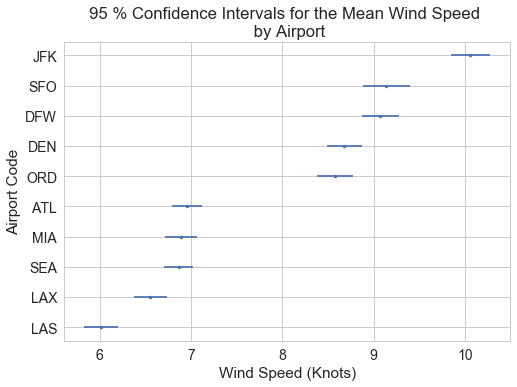

In [19]:
# plot the wind speed confidence intervals
plt.errorbar(x=df_ws.sample_mean, y=df_ws.index, xerr=df_ws.mem, marker='.', linestyle='none')
plt.yticks(df_ws.index, df_ws.station)
plt.xlabel('Wind Speed (Knots)')
plt.ylabel('Airport Code')
plt.title('95 % Confidence Intervals for the Mean Wind Speed \n by Airport')
plt.show()

In [20]:
# dataframe for visibility CI
df_v = df_mem['vsby']
df_v.columns = ['sample_mean','mem']
df_v = df_v.sort_values('sample_mean').reset_index()

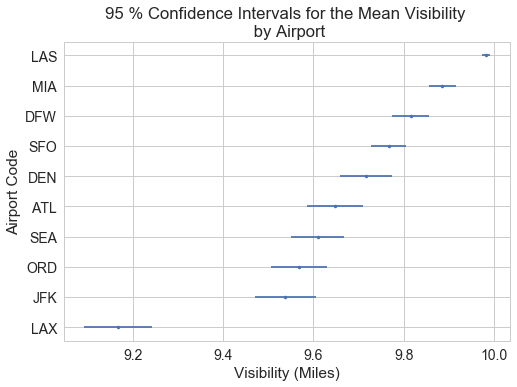

In [21]:
# plot the visibility confidence intervals
plt.errorbar(x=df_v.sample_mean, y=df_v.index, xerr=df_v.mem, marker='.', linestyle='none')
plt.yticks(df_v.index, df_v.station)
plt.xlabel('Visibility (Miles)')
plt.ylabel('Airport Code')
plt.title('95 % Confidence Intervals for the Mean Visibility \n by Airport')
plt.show()

## Correlations -- Delays and Weather Variables

NOTE: The analysis in the sections below is preliminary.  The full analysis will be conducted more thoroughly in later stages of the project.  

### Load the Pre-processed Data

In [22]:
# set the input directory
dir_in = 'C:/Users/Jonathon.Poage/Desktop/Springboard/Capstone_Documentation/Project_1/Data_Files/preprocessed_data/'

# set the input filepath
filename_in = 'merged_flight_weather_data_preprocessed.csv'
filepath_in = dir_in + filename_in

In [23]:
# columns to parse as dates
ts_cols_in = ['crs_dep_ts',
              'dep_ts',
              'wheels_off_ts',
              'valid']

# set dtype for each column
dict_dtype_in = {'QUARTER':np.int8,
                 'OP_UNIQUE_CARRIER':'category',
                 'OP_CARRIER_FL_NUM':np.int16,
                 'ORIGIN':'category',
                 'DEST':'category',
                 'DEP_TIME_BLK':'category',
                 'origin_timezone':'category',
                 'station':'category',
                 'skyc1':'category',
                 'skyc2':'category',
                 'skyc3':'category',
                 'skyc4':'category',
                 'skyl1':np.float64,
                 'skyl2':np.float64,
                 'skyl3':np.float64,
                 'skyl4':np.float64,
                 'wxcodes':'category',
                 'station_timezone':'category'}

In [24]:
# load the data -- should take about 1 minute
df = pd.read_csv(filepath_in,
                 parse_dates=ts_cols_in,
                 dtype=dict_dtype_in,
                 low_memory=False)

### Filter the Merged Data
Filter out all data points associated with positive values for the reported delay categories.  Focus on the relationships between departure delays and weather variables.

In [25]:
# filter the dataframe to compare delays with weather variables
df_corr = df[((df.CARRIER_DELAY == 0) | df.CARRIER_DELAY.isnull())
        & ((df.WEATHER_DELAY == 0) | df.WEATHER_DELAY.isnull())
        & ((df.NAS_DELAY == 0) | df.NAS_DELAY.isnull())
        & ((df.SECURITY_DELAY == 0) | df.SECURITY_DELAY.isnull())
        & ((df.LATE_AIRCRAFT_DELAY == 0) | df.LATE_AIRCRAFT_DELAY.isnull())]

### Correlation Matrix

In [26]:
# list of numeric weather variable column labels
numeric_weather_cols = ['tmpf',
                        'dwpf',
                        'relh',
                       # 'drct',   excluding wind direction because runway directions vary
                        'sknt',
                        'p01i',
                        'alti',
                        'mslp',
                        'vsby',
                        'gust',
                        'skyl1',
                        'skyl2',
                        'skyl3',
                        'skyl4']

corr_delay_weather = df_corr[['DEP_DELAY'] + numeric_weather_cols].corr()
corr_delay_weather

,DEP_DELAY,tmpf,dwpf,relh,sknt,p01i,alti,mslp,vsby,gust,skyl1,skyl2,skyl3,skyl4
DEP_DELAY,1.000000,0.025411,0.009435,-0.011335,0.031195,0.032427,-0.019235,-0.016698,-0.025909,0.013958,-0.035815,-0.027502,-0.032507,-0.035256
tmpf,0.025411,1.000000,0.610843,-0.306688,-0.031026,-0.028811,-0.217189,-0.334185,0.156292,-0.270423,0.023419,0.159016,0.255120,0.205754
dwpf,0.009435,0.610843,1.000000,0.519327,-0.071794,0.054806,-0.152110,-0.146095,-0.089932,-0.208900,-0.355735,-0.175212,-0.058894,0.074320
relh,-0.011335,-0.306688,0.519327,1.000000,-0.093852,0.130604,-0.016337,0.109172,-0.376263,0.022924,-0.494450,-0.467095,-0.458967,-0.210094
sknt,0.031195,-0.031026,-0.071794,-0.093852,1.000000,0.011117,-0.206278,-0.193519,0.060841,0.873201,-0.116230,-0.040001,-0.039992,0.027974
p01i,0.032427,-0.028811,0.054806,0.130604,0.011117,1.000000,-0.059077,-0.043095,-0.225505,0.036985,-0.081105,-0.126955,-0.167406,-0.068690
alti,-0.019235,-0.217189,-0.152110,-0.016337,-0.206278,-0.059077,1.000000,0.956807,0.075068,-0.246851,0.136712,0.107360,0.128678,0.077825
mslp,-0.016698,-0.334185,-0.146095,0.109172,-0.193519,-0.043095,0.956807,1.000000,0.033225,-0.221216,0.089610,0.047948,0.057240,0.086367
vsby,-0.025909,0.156292,-0.089932,-0.376263,0.060841,-0.225505,0.075068,0.033225,1.000000,-0.064919,0.248260,0.289337,0.341781,0.200392
gust,0.013958,-0.270423,-0.208900,0.022924,0.873201,0.036985,-0.246851,-0.221216,-0.064919,1.000000,-0.049186,-0.069560,-0.094663,-0.141294


It is possible to test the significance of the Pearson correlation coefficients between departure delays and each weather variable using t-tests.  This approach is not entirely appropriate, because the weather variables are predictors of departure delays. It is more appropriate to use regression models and Analysis of Variance (ANOVA). The analysis of the relationship between weather variables and departure delays is beyond the scope of the EDA.  The final analysis will include regression models and F-tests.   

The following tasks may be completed after the Machine Learning Unit:
1. Perform a multiple regression.  Model departure delay as a function of several weather variables.
2. Perform a linear regression between departure delays and each individual weather variable sequentially.  In each case, the other weather variables will be held fixed under certain conditions in order to best isolate the variation in delays with respect to the chosen weather variable.  